## Using Bayesian Optimisation for Hyperparameter Tuning of PINN model to solve the Linear Convection Diffusion equation

https://github.com/fmfn/BayesianOptimization</br>
https://towardsdatascience.com/bayesian-optimization-a-step-by-step-approach-a1cb678dd2ec</br>
https://en.wikipedia.org/wiki/Bayesian_optimization

Domain: $ x \in [-1,1] $ and $ t \in (0,1] $<br>
Initial Condition: $ u(0,x) = - \sin(\pi x) $<br>
Boundary Condition: $ u(t,-1) = u(t,1) = 0 $<br>

In [ ]:
import tensorflow as tf
import math as m

DTYPE = 'float32'
tf.keras.backend.set_floatx(DTYPE) # sets the default float type as 32-bit float
pi = tf.constant(m.pi, dtype=DTYPE)

def u_init(x): # calculates u value at initial data points
  return -tf.sin(pi * x)

def u_bound(t, x): # calculates u value at boundary data points
  n = x.shape[0]
  return tf.zeros((n,1), dtype=DTYPE)

In [ ]:
# Training Data

Ni, Nb, Nc = 50, 50, 10000 # no of initial, boundary and collocation points

tmin, tmax = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin, xmax = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti = tf.ones((Ni,1))*tmin # tmin repeated Ni times
xi = tf.random.uniform((Ni,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init = tf.concat([ti, xi], axis=1) # Initial Data Points
ui = u_init(xi) # Evaluate Initial Condition

tb = tf.random.uniform((Nb,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin = tf.keras.backend.random_bernoulli((Nb,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb = xmin + (xmax - xmin) * bin # convert 0s and 1s to xmin and xmax
bound = tf.concat([tb, xb], axis=1) # Boundary Data Points
ub = u_bound(tb, xb) # Evaluate Boundary Condition

tc = tf.random.uniform((Nc,1), tmin, tmax, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc = tf.random.uniform((Nc,1), xmin, xmax, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll = tf.concat([tc, xc], axis=1) # Collocation Data Points

In [ ]:
# Validation Data (in 1:5 ratio with training data)

Ni2, Nb2, Nc2 = 10, 10, 2000 # no of initial, boundary and collocation points

tmin2, tmax2 = tf.constant(0.), tf.constant(1.) # lower and upper limit on time
xmin2, xmax2 = -tf.constant(1.), tf.constant(1.) # lower and upper limit on x

tf.random.set_seed(0) # random seed for reproducible results

ti2 = tf.ones((Ni2,1))*tmin2 # tmin repeated Ni times
xi2 = tf.random.uniform((Ni2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
init2 = tf.concat([ti2, xi2], axis=1) # Initial Data Points
ui2 = u_init(xi2) # Evaluate Initial Condition

tb2 = tf.random.uniform((Nb2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
bin2 = tf.keras.backend.random_bernoulli((Nb2,1), 0.5, dtype=DTYPE) # randomly generate 0 or 1 Nb times
xb2 = xmin2 + (xmax2 - xmin2) * bin2 # convert 0s and 1s to xmin and xmax
bound2 = tf.concat([tb2, xb2], axis=1) # Boundary Data Points
ub2 = u_bound(tb2, xb2) # Evaluate Boundary Condition

tc2 = tf.random.uniform((Nc2,1), tmin2, tmax2, dtype=DTYPE) # uniformly sample bwn tmin and tmax
xc2 = tf.random.uniform((Nc2,1), xmin2, xmax2, dtype=DTYPE) # uniformly sample bwn xmin and xmax
coll2 = tf.concat([tc2, xc2], axis=1) # Collocation Data Points

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Model Hyperparameters Search Space:<br>
1. No of Hidden Layers = integer in range [1, 20]
2. No of Neurons = multiplier of 4 in range [4, 256]
3. Percentage Dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
4. Activation Function = relu, sigmoid, tanh, swish
5. Weight Initialiser = if relu then he else glorot (n/u)
6. Weight Regulariser = l2 [0, 10E-6 to 10E-1]

PDE $ u_t + c*u_x - v*u_{xx} = 0 $ with c = v = 1<br>

In [ ]:
v = tf.constant(1., dtype=DTYPE)
c = v

def f_val(u, u_t, u_x, u_xx): # calculates f value given u and its derivatives
  return u_t + c*u_x - v*u_xx

In [ ]:
def BlackBoxFunction(h, n, d, a, wi, wr):

  activations = [tf.keras.activations.get('relu'), tf.keras.activations.get('sigmoid'), tf.keras.activations.get('tanh'), tf.keras.activations.get('swish')]
  if round(a) == 0:
    init_wt = 'he_normal' if wi>0.5 else 'he_uniform'
  else:
    init_wt = 'glorot_normal' if wi>0.5 else 'glorot_uniform'

  reg = 0 if round(wr) == 0 else 10**(-round(wr))

  def u_model(n_hidden = round(h), n_neurons = 4*round(n)):
    model = tf.keras.Sequential() # Feed-Forward Neural Network
    model.add(tf.keras.Input(2)) # Input Layer for x and t
    scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
    model.add(scaling_layer)
    for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
      model.add(tf.keras.layers.Dense(n_neurons, activation=activations[round(a)], kernel_initializer=init_wt, kernel_regularizer=tf.keras.regularizers.l2(reg)))
      model.add(tf.keras.layers.Dropout(round(d)*0.1))
    model.add(tf.keras.layers.Dense(1)) # Output Layer for u
    return model

  def get_f(model, cps): # calculate f given model and collocation data points
    with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
      t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
      u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    del tape
    return f_val(u, u_t, u_x, u_xx)

  def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
    pui = model(init) # Model prediction on initial data
    Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
    pub = model(bound) # Model prediction on boundary data
    Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
    f = get_f(model, coll) # calculate f given model and collocation data
    Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true f value is 0)
    loss = Li + Lb + Lc
    return loss

  def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables) # keep track of operations on model training parameters
      loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

  model = u_model() # initialise the NN model
  lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
  optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

  @tf.function
  def train_step():
    # compute loss and its gradient wrt model parameters
    loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
    # perform gradient descent step to update the parameters
    optim.apply_gradients(zip(gradw, model.trainable_variables))

  # Training
  import warnings
  warnings.filterwarnings('ignore')
  N = 5000 # no of epochs or training iterations
  for i in range(1,N+1):
    train_step()

  val_loss = loss_fxn(model, init2, ui2, bound2, ub2, coll2)
  return -val_loss.numpy()

In [ ]:
import time
start = time.time()
param_BBF = {'h': (1, 20), 'n': (1, 64), 'd': (0, 5), 'a': (0, 3), 'wi': (0, 1), 'wr': (0, 6)} # Bounded region of parameter space
optimizer = BayesianOptimization(f=BlackBoxFunction, pbounds=param_BBF, verbose=2, random_state=1)
optimizer.maximize(init_points=2,n_iter=2)
print('It takes %s minutes' % ((time.time() - start)/60))
print(optimizer.max)

|   iter    |  target   |     a     |     d     |     h     |     n     |    wi     |    wr     |
-------------------------------------------------------------------------------------------------


|  1        | -0.01628  |  1.251    |  3.602    |  1.002    |  20.05    |  0.1468   |  0.554    |
|  2        | -0.464    |  0.5588   |  1.728    |  8.539    |  34.95    |  0.4192   |  4.111    |
|  3        | -0.003052 |  1.603    |  4.416    |  1.851    |  20.07    |  0.3825   |  0.1866   |
|  4        | -0.000113 |  3.0      |  5.0      |  4.825    |  6.731    |  1.0      |  0.0      |
It takes 276.48428111076356 minutes
{'target': -0.0001132071774918586, 'params': {'a': 3.0, 'd': 5.0, 'h': 4.82528068741232, 'n': 6.7309768252375735, 'wi': 1.0, 'wr': 0.0}}


In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
logger = JSONLogger(path="/content/logs.json")

In [ ]:
import time
start = time.time()
param_BBF = {'h': (1, 20), 'n': (1, 64), 'd': (0, 5), 'a': (0, 3), 'wi': (0, 1), 'wr': (0, 6)} # Bounded region of parameter space
optimizer = BayesianOptimization(f=BlackBoxFunction, pbounds=param_BBF, verbose=2, random_state=1)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=5,n_iter=10)
print('It took %s minutes' % ((time.time() - start)/60))
print(optimizer.max)

It took 60.771723870436354 minutes
{'target': -3.354094587848522e-05, 'params': {'a': 3.0, 'd': 5.0, 'h': 7.274840626165045, 'n': 17.346499578160596, 'wi': 0.0, 'wr': 0.0}}


In [ ]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
logger = JSONLogger(path="/content/logs_pde1.json")

In [ ]:
import time
start = time.time()
param_BBF = {'h': (1, 20), 'n': (1, 64), 'd': (0, 5), 'a': (0, 3), 'wi': (0, 1), 'wr': (0, 6)} # Bounded region of parameter space
optimizer = BayesianOptimization(f=BlackBoxFunction, pbounds=param_BBF, verbose=2, random_state=1)
optimizer.subscribe(Events.OPTIMIZATION_STEP, logger)
optimizer.maximize(init_points=5,n_iter=10)
print('It took %s minutes' % ((time.time() - start)/60))
print(optimizer.max)

It took 23.393388418356576 minutes
{'target': -4.620129766408354e-05, 'params': {'a': 3.0, 'd': 0.0, 'h': 5.244348862612832, 'n': 10.807176486065893, 'wi': 0.0, 'wr': 0.0}}


Best Model Hyperparameters:<br>
(Least Final Loss on Validation Data)<br>
Activation Function = Swish<br>
Weight Initialiser = Glorot Uniform<br>
Weight Regulariser = 0<br>
Dropout Rate = 0.5<br>
No of Hidden Layers = 7<br>
No of Neurons = 68

In [ ]:
def u_model(n_hidden = 7, n_neurons = 68):
  model = tf.keras.Sequential() # Feed-Forward Neural Network
  model.add(tf.keras.Input(2)) # Input Layer for x and t
  scaling_layer = tf.keras.layers.Lambda(lambda x: 2.0*(x - tf.stack([tmin, xmin]))/(tf.stack([tmax, xmax]) - tf.stack([tmin, xmin])) - 1.0)
  model.add(scaling_layer)
  for i in range(n_hidden): # n_hidden layers each with n_neurons and tanh activation
    model.add(tf.keras.layers.Dense(n_neurons, activation=tf.keras.activations.get('swish'), kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(0.5))
  model.add(tf.keras.layers.Dense(1)) # Output Layer for u
  return model

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
    with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
      t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
      tape.watch(t)
      tape.watch(x)
      u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
      u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
    u_t = tape.gradient(u, t)
    u_xx = tape.gradient(u_x, x)
    del tape
    return f_val(u, u_t, u_x, u_xx)

def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
    pui = model(init) # Model prediction on initial data
    Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
    pub = model(bound) # Model prediction on boundary data
    Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
    f = get_f(model, coll) # calculate f given model and collocation data
    Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true f value is 0)
    loss = Li + Lb + Lc
    return loss

def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
    with tf.GradientTape(persistent=True) as tape:
      tape.watch(model.trainable_variables) # keep track of operations on model training parameters
      loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
    g = tape.gradient(loss, model.trainable_variables)
    del tape
    return loss, g

In [ ]:
model = u_model() # initialise the NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

@tf.function
def train_step():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init_set, ui_set, bound_set, ub_set, coll_set)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  return loss

Final Loss = 2.8353745e-05
Computation Time = 114.32583332061768 seconds


Text(0, 0.5, 'Loss')

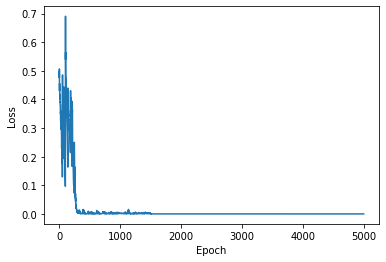

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses = []
t0 = time()
for i in range(1,N+1):
  loss = train_step()
  losses.append(loss.numpy())
print('Final Loss = '+str(losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [ ]:
N = 500
import numpy as np
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = model(input)
U = u_pred.numpy().reshape(N+1,N+1)

###Loss Decomposition

In [ ]:
def get_f(model, cps): # calculate f given model and collocation data points
  with tf.GradientTape(persistent=True) as tape: # track operations to compute gradient
    t, x = cps[:, 0:1], cps[:, 1:2] # extract t and x data each having shape (Nc,1)
    tape.watch(t)
    tape.watch(x)
    u = model(tf.concat([t, x], axis=1)) # u as a function of t and x
    u_x = tape.gradient(u, x) # defined within context to compute 2nd derivative
  u_t = tape.gradient(u, t)
  u_xx = tape.gradient(u_x, x)
  del tape
  return f_val(u, u_t, u_x, u_xx)

In [ ]:
def loss_fxn(model, init, ui, bound, ub, coll): # compute Loss given model and data
  pui = model(init) # Model prediction on initial data
  Li = tf.reduce_mean(tf.square(ui - pui)) # MSE for initial data
  pub = model(bound) # Model prediction on boundary data
  Lb = tf.reduce_mean(tf.square(ub - pub)) # MSE for boundary data
  f = get_f(model, coll) # calculate f given model and collocation data
  Lc = tf.reduce_mean(tf.square(f)) # MSE for collocation data (true f value is 0)
  loss = Li + Lb + Lc
  return [loss, Li, Lb, Lc]

In [ ]:
def L_and_grad_Lw(model, init, ui, bound, ub, coll): # compute gradient of loss wrt model weights
  with tf.GradientTape(persistent=True) as tape:
    tape.watch(model.trainable_variables) # keep track of operations on model training parameters
    loss = loss_fxn(model, init, ui, bound, ub, coll) # loss as a function of model (& hence weights)
  g = tape.gradient(loss[0], model.trainable_variables)
  del tape
  return loss, g

In [ ]:
model = u_model() # initialise the NN model
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1500,3500],[1e-2,1e-3,5e-4]) # decreasing learning rate which is piecewise constant
optim = tf.keras.optimizers.Adam(learning_rate=lr) # Adam optimizer

In [ ]:
@tf.function
def train_step_with_val():
  # compute loss and its gradient wrt model parameters
  loss, gradw = L_and_grad_Lw(model, init, ui, bound, ub, coll)
  # perform gradient descent step to update the parameters
  optim.apply_gradients(zip(gradw, model.trainable_variables))
  val_loss = loss_fxn(model, init2, ui2, bound2, ub2, coll2)
  return loss, val_loss

Final Training Loss Decomposition: Li = tf.Tensor(2.2274127e-05, shape=(), dtype=float32), Lb = tf.Tensor(2.736891e-05, shape=(), dtype=float32), Lc = tf.Tensor(6.0268663e-05, shape=(), dtype=float32)
Final Validation Loss Decomposition: Li = tf.Tensor(3.515243e-05, shape=(), dtype=float32), Lb = tf.Tensor(1.7644803e-05, shape=(), dtype=float32), Lc = tf.Tensor(6.0621715e-05, shape=(), dtype=float32)
Total Final Training Loss = 0.0001099117 and Total Final Validation Loss = 0.000113418944
Computation Time = 463.68392515182495 seconds


Text(0, 0.5, 'Loss')

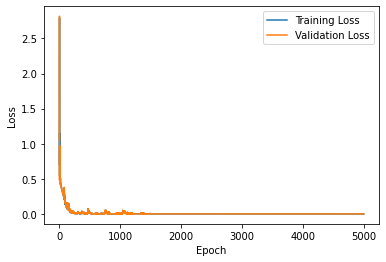

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from time import time
N = 5000 # no of epochs or training iterations
losses, val_losses = [], []
t0 = time()
for i in range(1,N+1):
  loss, val_loss = train_step_with_val()
  if i == N:
    TLi, TLb, TLc = loss[1].numpy(), loss[2].numpy(), loss[3].numpy()
    print('Final Training Loss Decomposition: Li = '+str(TLi)+', Lb = '+str(TLb)+', Lc = '+str(TLc))
    VLi, VLb, VLc = val_loss[1].numpy(), val_loss[2].numpy(), val_loss[3].numpy()
    print('Final Validation Loss Decomposition: Li = '+str(VLi)+', Lb = '+str(VLb)+', Lc = '+str(VLc))
  losses.append(loss[0].numpy())
  val_losses.append(val_loss[0].numpy())
print('Total Final Training Loss = '+str(losses[-1])+' and Total Final Validation Loss = '+str(val_losses[-1]))
print('Computation Time = {} seconds'.format(time()-t0))
epochs = [i for i in range(1,N+1)]
import matplotlib.pyplot as plt
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

###Plotting

In [ ]:
N = 500
import numpy as np
tspace = np.linspace(tmin, tmax, N+1)
xspace = np.linspace(xmin, xmax, N+1)
T, X = np.meshgrid(tspace, xspace)
grid = np.vstack([T.flatten(),X.flatten()]).T
input = tf.cast(grid,DTYPE)
u_pred = model(input)
U = u_pred.numpy().reshape(N+1,N+1)

In [ ]:
U

array([[ 2.73662657e-02,  2.47689560e-02,  2.23279819e-02, ...,
        -1.17796706e-04, -1.20928511e-04, -1.24489190e-04],
       [ 3.87564264e-02,  3.58927920e-02,  3.31930369e-02, ...,
        -6.17359765e-05, -6.53446186e-05, -6.93728216e-05],
       [ 5.01715392e-02,  4.70422432e-02,  4.40827943e-02, ...,
        -5.87687828e-06, -9.87830572e-06, -1.34399161e-05],
       ...,
       [-1.35531528e-02, -1.51865268e-02, -1.67391226e-02, ...,
        -6.54436462e-03, -6.58520777e-03, -6.62568584e-03],
       [ 2.69149663e-04, -1.58416433e-03, -3.35481158e-03, ...,
        -6.75509591e-03, -6.79528899e-03, -6.83505274e-03],
       [ 1.41297281e-02,  1.20556876e-02,  1.00671276e-02, ...,
        -6.96700625e-03, -7.00648688e-03, -7.04578031e-03]], dtype=float32)

Text(0.5, 0.92, 'PINN Solution')

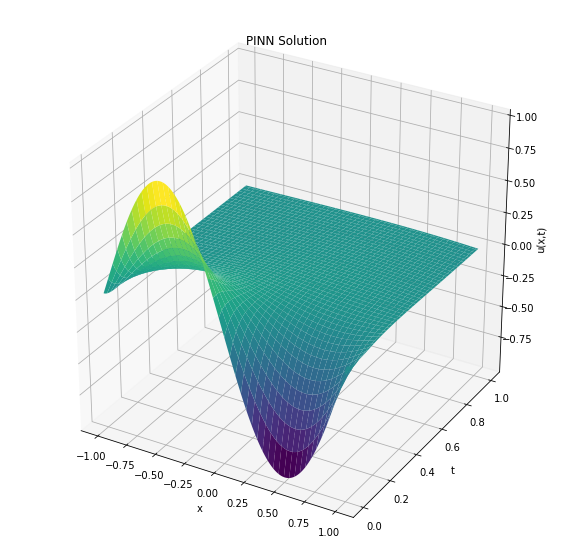

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X, T, U, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('PINN Solution')